## MNIST digits Classifier

In [1]:
#Basic Libraries
import numpy as np
import pandas as pd
#Used to import MNIST dataset
import scipy.io as sio
#Visualization libraries
import matplotlib.pyplot as plt
import cv2
#Helping libraries on model evaluation
from sklearn.metrics import accuracy_score 
#Script where the Neural Network Class is defined
import NN
#Script where the class to find the features of the neurons is defined
from FeatureDetector import FeatureDetector, plot_confusion_matrix
from FeatureDetector import HLFeaturesDetector as HLFD
from FeatureDetector import MidpointNormalize
#PyTorch utilities
import torch
import torch.nn as nn
import torch.optim as optim

### Data pre-processing

Here we load the dataset and inspect the istances

In [2]:
mnist = sio.loadmat('MNIST.mat')
X, y = mnist['input_images'], mnist['output_labels']
df = pd.DataFrame(X)
df['y'] = y
print('Shape of df: {}'.format(df.shape))
df.head()

Shape of df: (60000, 785)


,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,y
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0


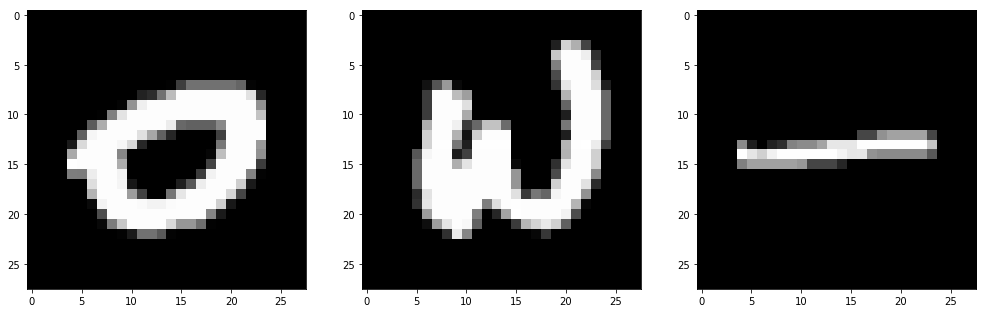

In [3]:
fig, ax = plt.subplots(1, 3, figsize=(17, 17))
ax[0].imshow(np.reshape(X[0, :], (28,28)), cmap='gray')
ax[1].imshow(np.reshape(X[40000, :], (28,28)), cmap='gray')
ax[2].imshow(np.reshape(X[-1, :], (28,28)), cmap='gray')
plt.show()

### Training the model

Here is where we define the training/test sets and the model  

In [4]:
train_size = n = 40000
#Define train/test set
x_train, y_train = df.iloc[:n, :-1].values, df.iloc[:n, -1].values
x_test, y_test = df.iloc[n:, :-1].values, df.iloc[n:, -1].values
### Initialize the network
h1, h2 = 64, 64
net = NN.Net(784, h1, h2, 10)
### Define the loss function
loss_fn = nn.CrossEntropyLoss()
### Define an optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=0.01, weight_decay=5e-4)

Here we call the fitting procedure

In [5]:
net.fit(x_train, y_train, x_test, y_test, loss_fn, optimizer, batch_size = 800, epochs = 40, verbose = 1, gpu = False)

Epoch 1 	Training loss: 0.4034	Validation loss: 0.396	Time: 5.0
Epoch 2 	Training loss: 0.2786	Validation loss: 0.2765	Time: 4.0
Epoch 3 	Training loss: 0.2318	Validation loss: 0.2359	Time: 5.0
Epoch 4 	Training loss: 0.206	Validation loss: 0.2132	Time: 4.0
Epoch 5 	Training loss: 0.1903	Validation loss: 0.199	Time: 4.0
Epoch 6 	Training loss: 0.1794	Validation loss: 0.1887	Time: 4.0
Epoch 7 	Training loss: 0.1717	Validation loss: 0.1811	Time: 4.0
Epoch 8 	Training loss: 0.166	Validation loss: 0.1753	Time: 4.0
Epoch 9 	Training loss: 0.1614	Validation loss: 0.1708	Time: 4.0
Epoch 10 	Training loss: 0.1573	Validation loss: 0.1673	Time: 4.0
Epoch 11 	Training loss: 0.1537	Validation loss: 0.1645	Time: 4.0
Epoch 12 	Training loss: 0.1505	Validation loss: 0.1622	Time: 4.0
Epoch 13 	Training loss: 0.1476	Validation loss: 0.1602	Time: 4.0
Epoch 14 	Training loss: 0.145	Validation loss: 0.1585	Time: 4.0
Epoch 15 	Training loss: 0.1427	Validation loss: 0.157	Time: 4.0
Epoch 16 	Training loss: 

Visualizing loss curve

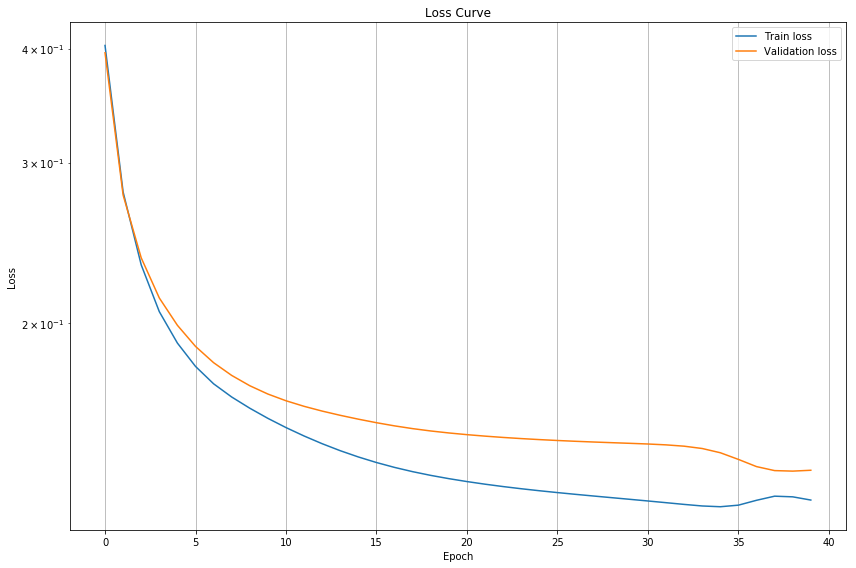

In [33]:
plt.figure(figsize=(12,8))
plt.semilogy(net.train_loss, label='Train loss')
plt.semilogy(net.val_loss, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

### Model Evaluation

Here is where we evaluate the model with some metrics

In [7]:
y_pred_train = net.predict(x_train, proba=False, gpu=False)
y_pred, y_proba = net.predict(x_test, proba=True, gpu = False)

validation_score, train_score = accuracy_score(y_pred, y_test), accuracy_score(y_pred_train, y_train)
print('Accuracy score on training: {}'.format(train_score))
print('Accuracy score on validation: {}'.format(validation_score))

Accuracy score on training: 0.97415
Accuracy score on validation: 0.96255


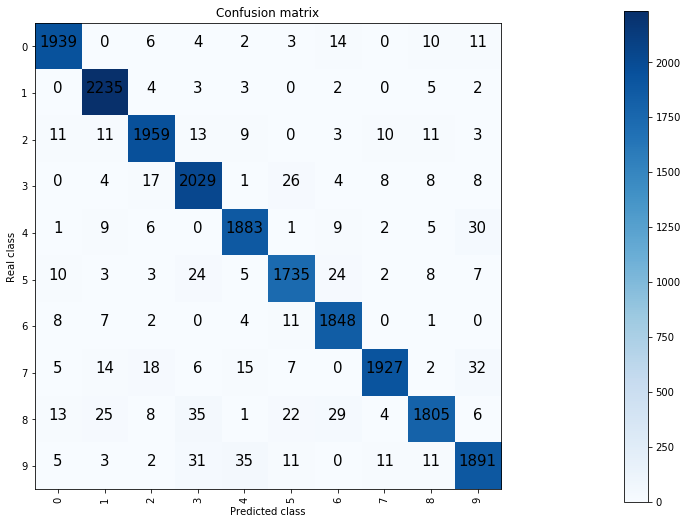

In [8]:
plot_confusion_matrix(y_true = y_test, y_pred = y_pred, 
                      classes = [str(i) for i in range(10)],
                      dim = 15, figs = (11, 11))

### Inspecting some activations of the neuron for a given input

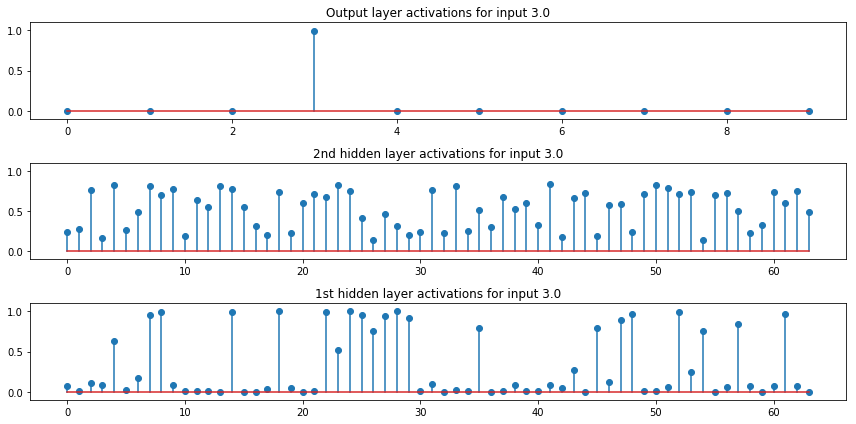

In [44]:
#Showing activations of the first validation istances
s = train_size 

net.eval()
with torch.no_grad():
    x1 = torch.tensor(df.iloc[s, :-1]).float()
    y, z1, z2, = net.forward(x1, additional_out=True)
    y = nn.functional.softmax(y, dim = -1).squeeze()

fig, axs = plt.subplots(3, 1, figsize=(12,6))
axs[0].stem(y.numpy())
axs[0].set_title('Output layer activations for input {}'.format(df.y[s]))
axs[0].set_ylim([-.1, 1.1])
axs[1].stem(z2.numpy())
axs[1].set_ylim([-.1, 1.1])
axs[1].set_title('2nd hidden layer activations for input {}'.format(df.y[s]))
axs[2].stem(z1.numpy())
axs[2].set_ylim([-.1, 1.1])
axs[2].set_title('1st hidden layer activations for input {}'.format(df.y[s]))
plt.tight_layout()
plt.show()

### Inspecting specific target neuron

Thanks to the FeatureDetection class, we can perform gradient descent w.r.t to the input in order to maximise the activation of a specific neuron. It could be a neuron in the hidden layer or a neuron in the output layer.


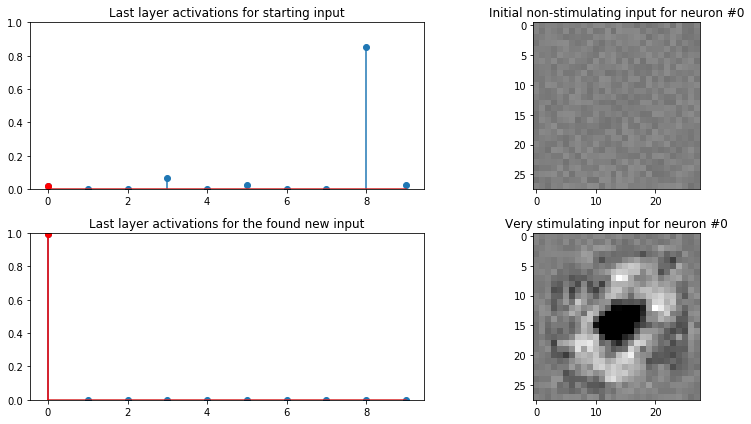

In [51]:
# Position of neuron to inspect 
layer = 3 #Layer=1: 1st hidden layer, Layer=2:2nd hidden layer, #Layer=3: Output layet
neuron = 0 #Position of the neuron in the given layer

#Paramters of the algorithm
bounds, init_ranges = b, bs = (0, 1), (0.45, 0.55) #Bounds for the input, ranges from the starting random input
target = t = 1 #Output of the neuron that we want to reach
lr = 20 #Learning rate
max_iter = mi = 200 #Max number of iteration
figsize = fs = (11.5, 6) #Figure sizes

#Initializing the HighLevelFeatureDetector
detector = HLFD(model=net, n_features=X.shape[1], target=1)

#Running the alogirthm. Returns the starting input (old) and the input which maximise the output activation (new) 
old, new = detector.get_features(n_pos=neuron, layer = layer, 
                                 bounds=b, start_bounds=bs, 
                                 lr = lr, max_iter = mi)

#Calling an object for mapping the starting_input in HLFD.plot_diff
vmean = np.mean([np.min(bs), np.max(bs)])
norm = MidpointNormalize(vmin = np.min(bs), vmax = np.max(bs), vcenter = vmean)

#Display results
detector.plot_diff(old, new, neuron, layer, fs, normalizer=MidpointNormalize)

### Plotting important features
Here we perform Gradient Descent w.r.t to input for findings the inputs which maximise the activation functions of all the neurons in a given layer.

In [61]:
#Init lists
olds_v, news_v = [], []

#Telling how many neurons we have to inspect. 
if layer == 3:
    num = 10
elif layer == 2:
    num = h2
else:
    num = h1
    
#Running the algorithm for every neuron on that layer
for i in range(num):
    #Running Algorithm
    old, new = detector.get_features(n_pos=i, layer = layer,
                                     bounds=b, start_bounds=bs, 
                                     lr = lr, max_iter = mi)
    #Saving the results
    olds_v.append(old), news_v.append(new)

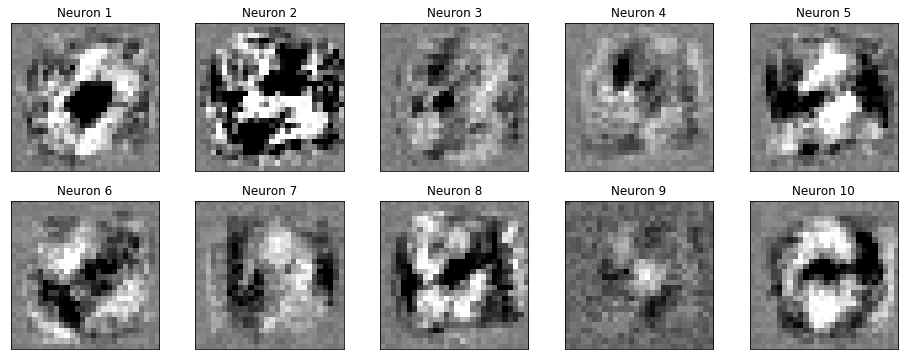

In [62]:
#Reshaping the inputs
news_img = [np.reshape(np.array(i), (28, 28)) for i in news_v]

#Parameters for displaying all the inputs
if layer == 3:
    n_row, n_col = 2, 5
    figsize=(16, 6)
else:
    n_row = n_col = int(h1**0.5) 
    figsize=(16, 16)
    
#Plotting the stimulating inputs
fig, ax = plt.subplots(n_row, n_col, figsize = figsize)
for i in range(n_row):
    for j in range(n_col):
        img = news_img[n_col*i + j] #the int is the range of j e.g for j in range(8), then 8*i
        ax[i, j].imshow(img, cmap='gray') 
        ax[i, j].set_title('Neuron {}'.format(n_col*i + j + 1), fontsize=12)
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
plt.show()

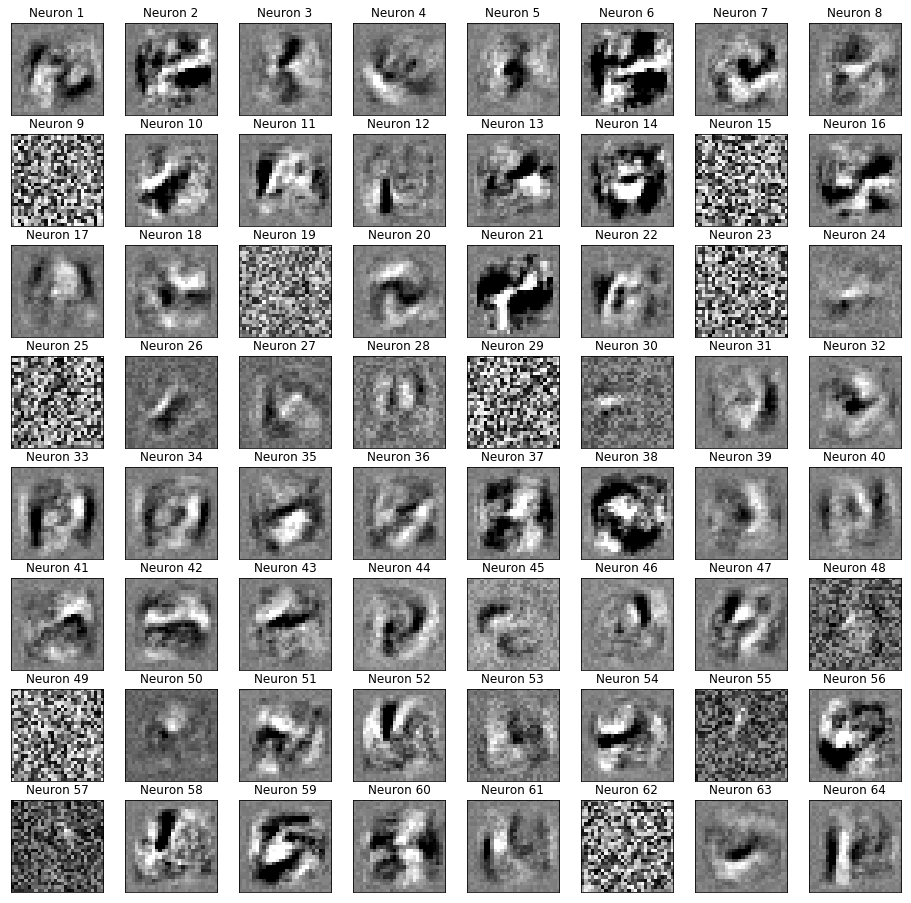

In [63]:
#Init lists
olds_v, news_v = [], []
    
#Running the algorithm for every neuron on that layer
for i in range(h1):
    #Running Algorithm
    old, new = detector.get_features(n_pos=i, layer = 1,
                                     bounds=b, start_bounds=bs, 
                                     lr = lr, max_iter = mi)
    #Saving the results
    olds_v.append(old), news_v.append(new)

#Reshaping the inputs
news_img = [np.reshape(np.array(i), (28, 28)) for i in news_v]

#Parameters for displaying all the inputs
n_row = n_col = int(h1**0.5) 
figsize=(16, 16)
    
#Plotting the stimulating inputs
fig, ax = plt.subplots(n_row, n_col, figsize = figsize)
for i in range(n_row):
    for j in range(n_col):
        img = news_img[n_col*i + j] #the int is the range of j e.g for j in range(8), then 8*i
        ax[i, j].imshow(img, cmap='gray') 
        ax[i, j].set_title('Neuron {}'.format(n_col*i + j + 1), fontsize=12)
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
plt.show()

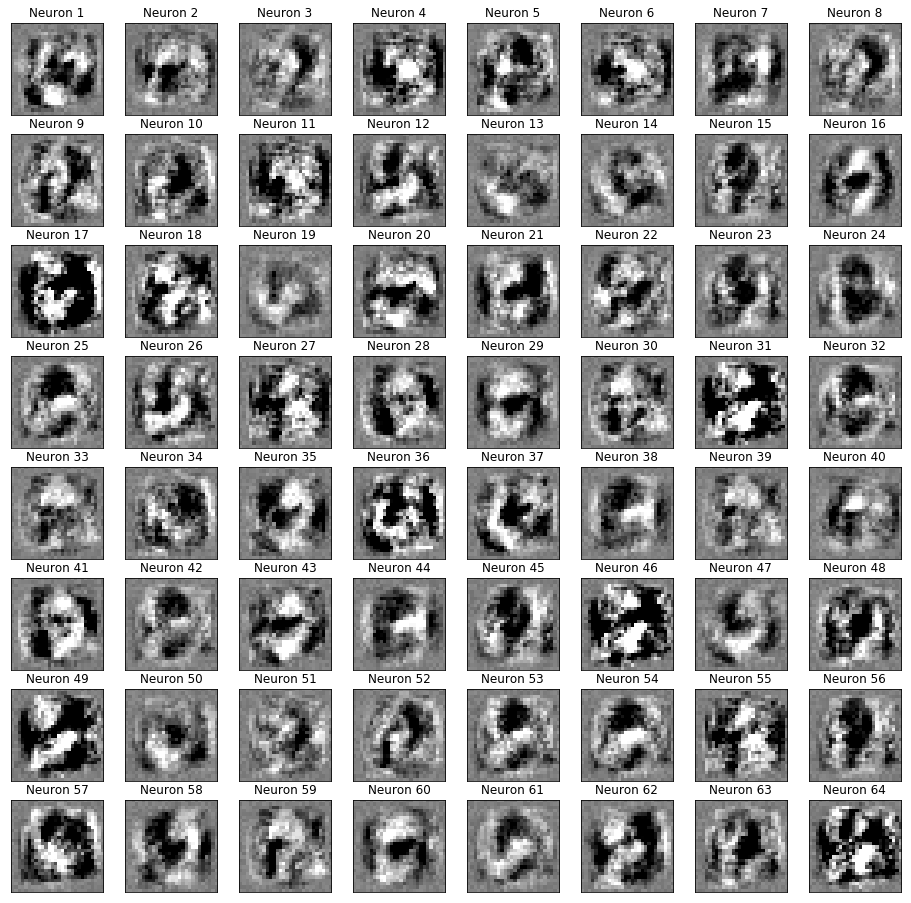

In [64]:
#Init lists
olds_v, news_v = [], []
    
#Running the algorithm for every neuron on that layer
for i in range(h2):
    #Running Algorithm
    old, new = detector.get_features(n_pos=i, layer = 2,
                                     bounds=b, start_bounds=bs, 
                                     lr = lr, max_iter = mi)
    #Saving the results
    olds_v.append(old), news_v.append(new)

#Reshaping the inputs
news_img = [np.reshape(np.array(i), (28, 28)) for i in news_v]

#Parameters for displaying all the inputs
n_row = n_col = int(h1**0.5) 
figsize=(16, 16)
    
#Plotting the stimulating inputs
fig, ax = plt.subplots(n_row, n_col, figsize = figsize)
for i in range(n_row):
    for j in range(n_col):
        img = news_img[n_col*i + j] #the int is the range of j e.g for j in range(8), then 8*i
        ax[i, j].imshow(img, cmap='gray') 
        ax[i, j].set_title('Neuron {}'.format(n_col*i + j + 1), fontsize=12)
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
plt.show()

### Save MODEL
Here we save the model using the date and the time of the saving, in order to avoid overwriting of models

In [32]:
file_name = 'model_at_{}'.format(dt_string)
torch.save(net, file_name)
print('Model saved at: {}'.format(file_name))

Model saved at: model_at_08_11_2019_00h_41m_16s


In [21]:
net1 = torch.load('model')

### Grid Search

In [15]:
import time
from scipy.stats import randint as sp_randint
from sklearn.model_selection import KFold

# specify parameters and distributions to sample from
params = {"h1": [32, 64, 128], 
          "h2": [32, 64, 128], 
          "lr": [0.01, 0.05, 0.1], 
          "wd": [5e-5, 1e-4], 
          "batch": [100, 200]}

models = {}
n = 0
for h1 in params['h1']:
    for h2 in params['h2']:
        for lr in params['lr']:
            for wd in params['wd']:
                for b in params['batch']:
                    models['M{}'.format(n)] = {'h1': h1, 'h2': h2, 'lr': lr, 'wd': wd, 'batch': b}
                    n += 1

In [16]:
results = {}
tot_time = time.time()
for m in models:
    
    print('------------------')
    print('Starting model: {}'.format(models[m]))
    print('------------------')
    s_time = time.time()
    
    ### Init CV
    cv = KFold(n_splits=3, random_state=42, shuffle=True)
    results[m] = {'model_params': models[m], 'score_train': [], 'score_test': []}
    
    cv_iter = 0
    ### Start CV
    for i,j in cv.split(X):
        cv_iter += 1
        print('Starting CV {}'.format(cv_iter))
        x_train, y_train = X[i], np.reshape(y[i], (-1,))
        x_test, y_test = X[j], np.reshape(y[j], (-1,))
        
        ### Initialize the network
        net = NN.Net(784, models[m]['h1'], models[m]['h2'], 10)
        loss_fn = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(net.parameters(), lr=models[m]['lr'], weight_decay=models[m]['wd'])
        
        ### Fit network
        net.fit(x_train, y_train, x_test, y_test, loss_fn, optimizer, 
                batch_size = models[m]['batch'], epochs = 25, verbose = 3, gpu = False)
        
        ### Get accuracy
        y_pred_train = net.predict(x_train, proba=False, gpu=False)
        y_pred_test = net.predict(x_test, proba=False, gpu = False)        
        train_score, validation_score = accuracy_score(y_pred_train, y_train), accuracy_score(y_pred_test, y_test)

        ### Save results of CV
        results[m]['score_train'].append(accuracy_score)
        results[m]['score_train'].append(accuracy_score)
        results[m]['score_train'].append(accuracy_score)
        
        ### Print results
        print('Accuracy score on training: {}'.format(train_score))
        print('Accuracy score on validation: {}'.format(validation_score))
        print('Total time of iteration: {}'.format(time.time()-s_time))
        if cv_iter < 3:
            print('-------------')
        
print('Procedure ended in {}'.format(time.time()-tot_time))

------------------
Starting model: {'h1': 32, 'h2': 32, 'lr': 0.01, 'wd': 5e-05, 'batch': 100}
------------------
Starting CV 1
Epoch 1 	Training loss: 0.2787	Validation loss: 0.2384	Time: 4.0
Epoch 4 	Training loss: 0.1316	Validation loss: 0.1524	Time: 4.0
Epoch 7 	Training loss: 0.0917	Validation loss: 0.17	Time: 4.0
Epoch 10 	Training loss: 0.116	Validation loss: 0.1533	Time: 4.0
Epoch 13 	Training loss: 0.1058	Validation loss: 0.1632	Time: 4.0
Epoch 16 	Training loss: 0.088	Validation loss: 0.1458	Time: 4.0


KeyboardInterrupt: 